**Parameters**  
Available Graphviz layout programs for ```prog``` can be found at [https://graphviz.org/docs/layouts/](https://graphviz.org/docs/layouts/).  
Colours are assigned to each flow in ```flows_dir``` in alphabetical order; defaults to black.  

In [ ]:
# files
flows_dir = "flows"

# graph drawing
prog = "neato"
colours = [
    "#f15060",
    "#000000"
]

**Imports**

In [65]:
import matplotlib.patches
import matplotlib.pyplot as plt
import networkx as nx

import colorsys
import csv
import json
import os
import statistics
from typing import Dict, Hashable, List, Tuple

**Helper functions**

In [66]:
def draw_multidigraph(G: nx.MultiDiGraph, pos: Dict[Hashable, Tuple[float]], flow_names: List[str],
                      colours: List[str] = [], ax=None,
                      node_radius=7.5, node_font_size=12.0,
                      edge_max_rad=0.4, edge_width=2.0, arrow_size=12.0,
                      edge_font_size=10.0) -> None:
    colour_set = []
    for colour in colours:
        hexcode = ["0x" + colour.strip().split('#')[-1][i:i+2]
               for i in range(len(colour.strip().split('#')[-1][::2]))]
        rgb_dark = [int(h, 0) / 255 for h in hexcode]
        hsv = colorsys.rgb_to_hsv(rgb_dark[0], rgb_dark[1], rgb_dark[2])
        rgb_light = colorsys.hsv_to_rgb(hsv[0], 0.5 * hsv[1], 0.5 + 0.5 * hsv[2])
        rgb_medium = colorsys.hsv_to_rgb(hsv[0], 0.75 * hsv[1], 0.25 + 0.75 * hsv[2])
        hex_light = '#' + ''.join([('0' + hex(round(rgb * 255)).split("0x")[-1])[-2:] for rgb in rgb_light])
        hex_medium = '#' + ''.join([('0' + hex(round(rgb * 255)).split("0x")[-1])[-2:] for rgb in rgb_medium])
        colour_set.append((hex_light, hex_medium, colour))
    if len(colour_set) < len(flow_names):
        colour_set += [["#808080", "#bfbfbf", "#000000"] for i in range(len(flow_names) - len(colour_set))]

    # draw nodes
    radii = [node_radius / len(flow_names) * (i + 1) for i in range(len(flow_names))]
    for node in G.nodes():
        node_colours = ["#000000" for i in flow_names]
        colour_index = 1
        if G.in_degree(node) == 0:
            colour_index = 0
        elif G.out_degree(node) == 0:
            colour_index = 2
        for i in range(len(colour_set)):
            node_colours[i] = colour_set[i][colour_index]

        idx = [flow_names.index(membership) for membership in G.nodes[node]["membership"]]
        circles = [matplotlib.patches.Circle(
            pos[node],
            radius=radii[-1] if len(idx) == 1 else radii[i],
            color=node_colours[i],
            fill=True if len(idx) == 1 or (len(idx) > 1 and i == 0) else False
        ) for i in idx]
        for circle in circles:
            ax.add_patch(circle)

    # draw node labels
    nx.draw_networkx_labels(
        G,
        {node: (xy[0], xy[1] - node_radius) for node, xy in pos.items()},
        horizontalalignment="left",
        font_size=node_font_size,
        ax=ax
    )

    # draw edges and labels
    max_parallel_edges = 0
    for start, end in G.edges():
        if max_parallel_edges < len(G[start][end]):
            max_parallel_edges = len(G[start][end])
    connectionstyle = [f"arc3,rad={(2 * edge_max_rad) / (max_parallel_edges - 1) * i - edge_max_rad}"\
                       for i in range(max_parallel_edges)]
    labels = []
    pathpatches = []
    edge_idx = {}
    for start, end, key in G.edges(keys=True):
        labels.append(key)
        if not (start, end) in edge_idx:
            edge_idx[(start, end)] = 0
        else:
            edge_idx[(start, end)] += 1
        num_parallel_edges = len(G[start][end])
        flow = key.split('_')[0]
        edge_colour = colour_set[flow_names.index(flow)][2]
        start_idx = (max_parallel_edges - num_parallel_edges) // 2
        edge_connectionstyle = connectionstyle[start_idx:start_idx + num_parallel_edges][edge_idx[(start, end)]]
        pathpatch = nx.draw_networkx_edges(G, pos, ax=ax,
            edgelist=[(start, end)], edge_color=edge_colour, connectionstyle=edge_connectionstyle,
            width=edge_width, arrows=True, arrowsize=arrow_size, node_size=150 * node_radius)
        pathpatches.append(pathpatch[0])

    for i in range(len(labels)):
        s = labels[i]
        vertices = pathpatches[i].get_path().vertices
        xs = [vertex[0] for vertex in vertices]
        ys = [vertex[1] for vertex in vertices]
        x = ((xs[0] + xs[2]) / 2 + xs[1]) / 2
        y = ((ys[0] + ys[2]) / 2 + ys[1]) / 2
        ax.text(x, y, s, fontsize=edge_font_size, horizontalalignment="center", verticalalignment="center")

**Graph**

In [67]:
flow_fps = {}
for root, dirs, files in os.walk(flows_dir):
    flow_fps = {'.'.join(file.split('.')[:-1]): os.path.join(flows_dir, file) for file in files}
flows = {}
flow_names = []
for flow_name, flow_fp in flow_fps.items():
    flow_names.append(flow_name)
    nodes = {}
    with open(flow_fp, 'r') as fp:
        reader = csv.reader(fp)
        next(reader)
        for row in reader:
            node = row[0]
            ins = {}
            outs = {}
            if row[1]:
                ins = {f"{flow_name}_{edge.strip().split()[1]}":
                       float(edge.strip().split()[0]) for edge in row[1].split(';')}
            if row[2]:
                outs = {f"{flow_name}_{edge.strip().split()[1]}":
                        float(edge.strip().split()[0]) for edge in row[2].split(';')}
            nodes[node] = {"in": ins, "out": outs}
        flows[flow_name] = nodes

In [68]:
flows_edges = {}
for flow_name, flow in flows.items():
    edges = {}
    for node, in_out in flow.items():
        for edge, ratio in in_out["in"].items():
            if not edge in edges:
                edges[edge] = {
                    "nodes": [None, None],
                    "ratios": [0, 0] 
                }
            edges[edge]["nodes"][1] = node
            edges[edge]["ratios"][1] = ratio
        for edge, ratio in in_out["out"].items():
            if not edge in edges:
                edges[edge] = {
                    "nodes": [None, None],
                    "ratios": [0, 0] 
                }
            edges[edge]["nodes"][0] = node
            edges[edge]["ratios"][0] = ratio
    flows_edges[flow_name] = edges

G_flows = {}
for flow_name, flow in flows.items():
    G_flow = nx.MultiDiGraph()
    G_flow.add_nodes_from([node for node in flow.keys()])
    for edge in flows_edges[flow_name]:
        nodes = flows_edges[flow_name][edge]["nodes"]
        ratios = flows_edges[flow_name][edge]["ratios"]
        if not (nodes[0] and nodes[1]):
            continue
        G_flow.add_edge(nodes[0], nodes[1], key=edge, ratioStart=ratios[0], ratioEnd=ratios[1])
    G_flows[flow_name] = G_flow

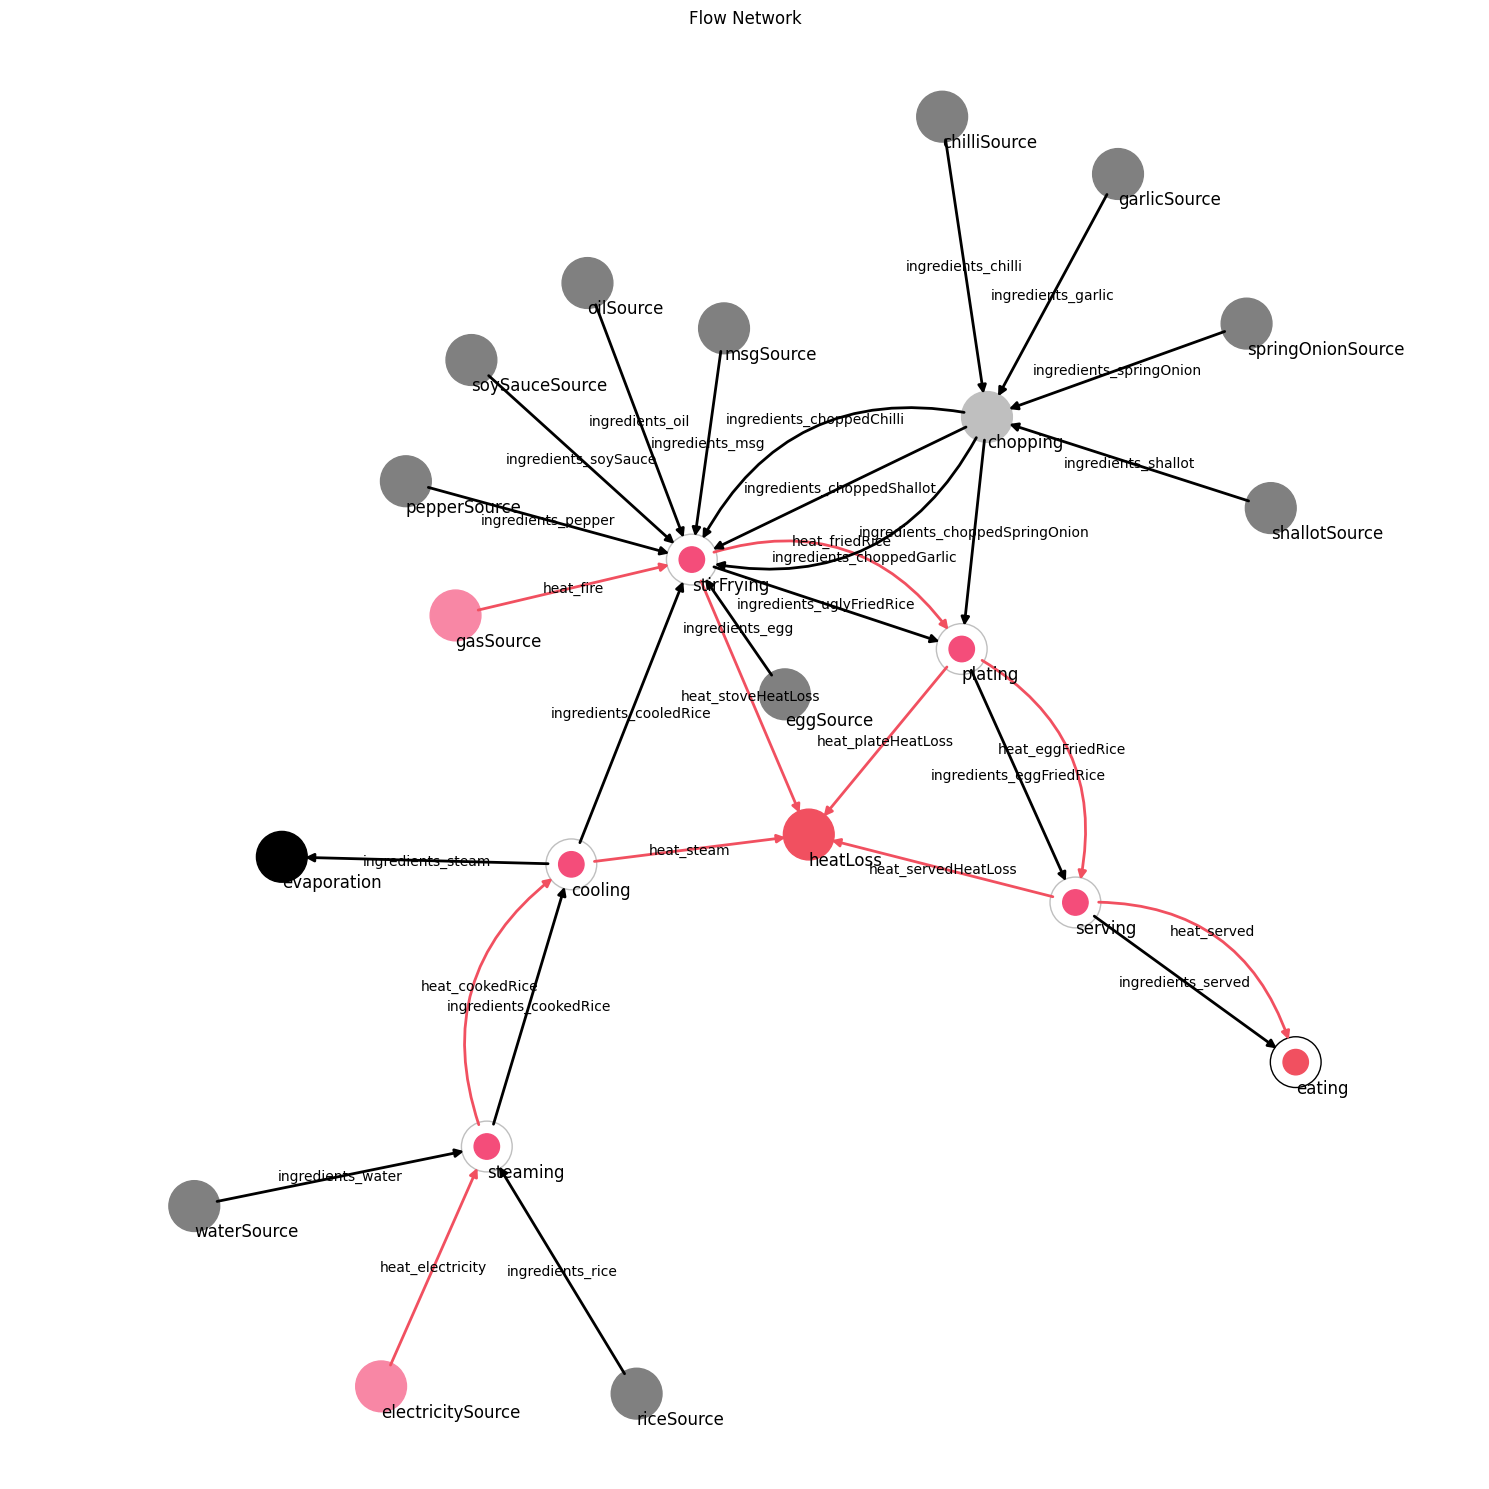

In [69]:
G_composed = None
for flow_name, G_flow in G_flows.items():
    if not G_composed:
        G_composed = G_flow
    else:
        G_composed = nx.compose(G_composed, G_flow)
memberships = {}
for node in G_composed.nodes():
    if not node in memberships:
        memberships[node] = set()
    for other, edges in G_composed[node].items():
        if not other in memberships:
            memberships[other] = set()
        for edge in G_composed[node][other].keys():
            memberships[node].add(edge.split('_')[0])
            memberships[other].add(edge.split('_')[0])
nx.set_node_attributes(G_composed, memberships, "membership")

pos = nx.nx_agraph.graphviz_layout(G_composed, prog="neato")
fig, ax = plt.subplots(figsize=(15, 15))
draw_multidigraph(G_composed, pos,
                  flow_names=flow_names, colours=colours, ax=ax,
                  node_radius=7.5, node_font_size=12.0,
                  edge_max_rad=0.4, edge_width=2.0, arrow_size=12.0,
                  edge_font_size=10.0)
ax.axis('equal')
ax.axis('off')
ax.set_title('Flow Network')
plt.tight_layout()
plt.show()